In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os, sys


# Set seed
torch.manual_seed(0)
from torch.optim.lr_scheduler import StepLR



In [1]:
!test -d optimal_quantization || git clone https://github.com/JTT94/optimal_quantization.git 
if not 'optimal_quantization' in sys.path:
  sys.path.append('optimal_quantization')


Cloning into 'optimal_quantization'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 108 (delta 38), reused 79 (delta 19), pack-reused 0
Receiving objects: 100% (108/108), 23.60 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [0]:
sys.path.append("./optimal_quantization")

from src.utils import uniform_weights
from src.ground_cost import l2_cost2, l2_cost, batch_l2_cost2
from src.discrete_entropic_reg import (soft_c_transform, 
                                       soft_exponential_cost, 
                                       normalised_soft_exponential_cost, 
                                       stochastic_dual_approx)

from src.trainer import Trainer
from src.quantizer import Quantizer
from src.schedulers import scheduler_constructor
from src.plots import arrow_plot, scatter_plot

## Uniform Distribution

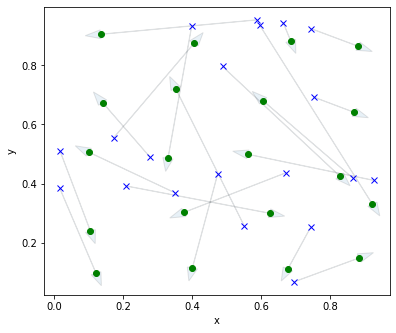

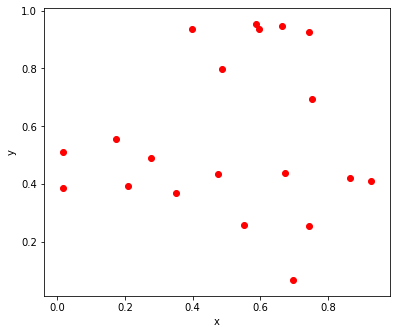

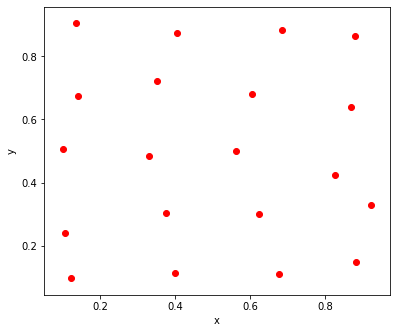

In [5]:
num_atoms = 20
dim = 2
init_g = np.random.random(size = (num_atoms))
init_ys = np.random.random(size = (num_atoms, dim))
epsilon = 0.01

quantizer_obj = Quantizer(init_g, init_ys, epsilon, ground_cost=batch_l2_cost2)

alpha_dist = dist.Uniform(torch.tensor(np.repeat(0., dim)), torch.tensor(np.repeat(1., dim)))


# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([quantizer_obj.ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([quantizer_obj.g], lr=learning_rate)

trainer = Trainer(alpha_dist, 
                  quantizer_obj, 
                  optimizer_map, 
                  optimizer_atoms, 
                  map_scheduler_func = scheduler_constructor(0.8), 
                  atoms_scheduler_func=scheduler_constructor(0.8))

trainer.train(n_iters=10000, batch_size=1, n_sub_iters_atoms=10, n_sub_iters_map=10, lr_steps=100)

final_ys = quantizer_obj.ys.detach().numpy()
arrow_plot(init_ys, final_ys, head_width = 0.03)

scatter_plot(init_ys[:,0],init_ys[:,1])
scatter_plot(final_ys[:,0],final_ys[:,1])

## Gaussian Distribution

Need to restart kernel between experiments, some bug


In [0]:
num_atoms = 500
dim = 2
init_g = np.random.random(size = (num_atoms))
init_ys = np.random.random(size = (num_atoms, dim))
epsilon = 0.01

gaus_quantizer_obj = Quantizer(init_g, init_ys, epsilon, ground_cost=batch_l2_cost2)

gaus_alpha_dist = dist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,0.],[0.,1.]]))


# optimizers
learning_rate = 0.1
gaus_optimizer_atoms = torch.optim.ASGD([gaus_quantizer_obj.ys], lr=learning_rate)
gaus_optimizer_map = torch.optim.ASGD([gaus_quantizer_obj.g], lr=learning_rate)

gaus_trainer = Trainer(gaus_alpha_dist, 
                  gaus_quantizer_obj, 
                  gaus_optimizer_map, 
                  gaus_optimizer_atoms, 
                  map_scheduler_func = scheduler_constructor(0.9), 
                  atoms_scheduler_func=scheduler_constructor(0.9))

In [0]:
gaus_trainer.train(n_iters=5000, batch_size=1, n_sub_iters_atoms=10, n_sub_iters_map=10, lr_steps=500)

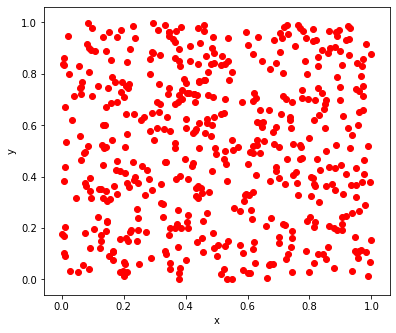

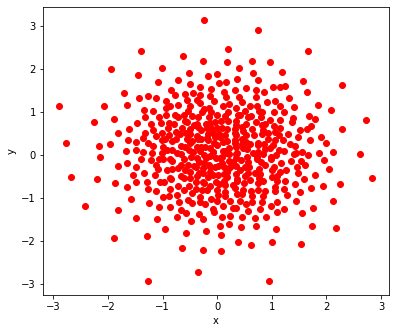

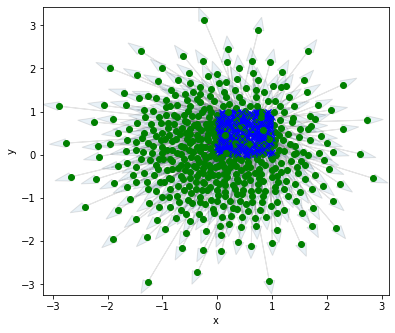

In [0]:
final_ys = gaus_quantizer_obj.ys.detach().numpy()
scatter_plot(init_ys[:,0],init_ys[:,1])
scatter_plot(final_ys[:,0],final_ys[:,1])
arrow_plot(init_ys, final_ys, head_width = 0.2)

In [0]:
np.mean(final_ys, axis = 0), np.cov(final_ys[:,0], final_ys[:,1])


(array([0.05798228, 0.06973765]), array([[ 0.97526428, -0.012152  ],
        [-0.012152  ,  0.95966016]]))

In [0]:
samples = np.random.normal(size = (num_atoms, dim))
np.mean(samples, axis = 0), np.cov(samples[:,0], samples[:,1])

(array([-0.02653736,  0.02344013]), array([[0.97876192, 0.02127219],
        [0.02127219, 1.07048083]]))

## Gaussian Mixture

Need to restart kernel between experiments, some bug


In [0]:
class GausMix(object):
    def __init__(self, mu1 = [-3.,-3.],mu2= [3.,3.], p = 0.5):
        self.mu1 = mu1
        self.mu2 = mu2
        self.p = p
        
        self.dist1 = dist.MultivariateNormal(torch.tensor(self.mu1), torch.tensor([[1.,0.],[0.,1.]]))
        self.dist2 = dist.MultivariateNormal(torch.tensor(self.mu2), torch.tensor([[1.,0.],[0.,1.]]))
        self.uniform_dist = dist.Uniform(torch.tensor(0.), torch.tensor(1.))
        
    
    def sample_one(self):
        if self.uniform_dist.sample() < self.p:
            return self.dist1.sample()
        else:
            return self.dist2.sample()
        
    def sample(self, sample_shape = (1,)):
        num = sample_shape[0]
        output = []
        for _ in range(num):
            output.append(self.sample_one())
        return torch.stack(output)
        
        

In [0]:
num_atoms = 100
dim = 2
init_g = np.random.random(size = (num_atoms))
init_ys = np.random.random(size = (num_atoms, dim))
epsilon = 0.1

mix_quantizer_obj = Quantizer(init_g, init_ys, epsilon, ground_cost=batch_l2_cost2)

mix_alpha_dist = GausMix()


# optimizers
learning_rate = 0.1
mix_optimizer_atoms = torch.optim.ASGD([mix_quantizer_obj.ys], lr=learning_rate)
mix_optimizer_map = torch.optim.ASGD([mix_quantizer_obj.g], lr=learning_rate)

mix_trainer = Trainer(mix_alpha_dist, 
                  mix_quantizer_obj, 
                  mix_optimizer_map, 
                  mix_optimizer_atoms, 
                  map_scheduler_func = scheduler_constructor(0.8), 
                  atoms_scheduler_func=scheduler_constructor(0.8))

In [0]:
mix_trainer.train(n_iters=2000, batch_size=1, n_sub_iters_atoms=10, n_sub_iters_map=10, lr_steps=500)

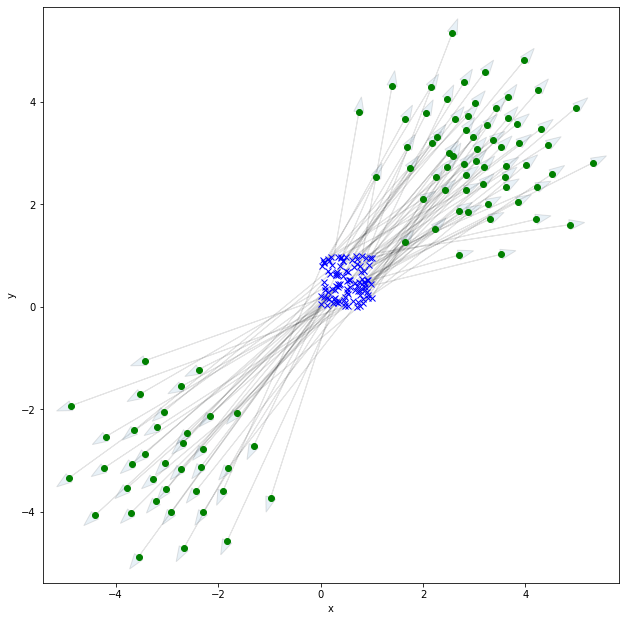

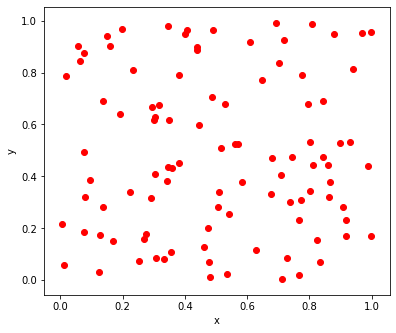

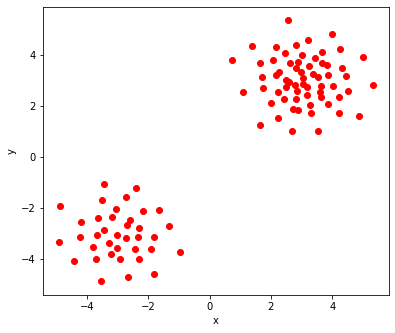

In [0]:
final_ys = mix_trainer.quantizer.ys.detach().numpy()
arrow_plot(init_ys, final_ys, head_width = 0.2, fig_size=(10,10))

scatter_plot(init_ys[:,0],init_ys[:,1])
scatter_plot(final_ys[:,0],final_ys[:,1])